In [1]:
import os
import sys

# Get the current working directory
current_dir = os.getcwd()
# Add the ./src folder to the Python module search path
sys.path.append(os.path.join(current_dir, '..', 'src'))

from utils import *
from optimize_symmetric import *
from train_test_symmetric import *

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline


from scipy import stats
from scipy.optimize import minimize
from scipy.stats import pearsonr
from scipy.stats import ks_2samp


import xgboost as xgb


sns.set_style('ticks')

### 1. read sparse and dense feature sets

In [6]:
input_path = './Data/'

# Seleted Mordred Descriptors
features_file_1 = 'Features/selection_cleanMordredDescriptors.csv'
# Full deepnose updated features 
features_file_2 =  'Features/deepnose_features_UPD.npy'

# Morgan fingerprint 50 dimension
features_file_3a = 'Features/Morgan_Fingerprints_Frequency_Size50.csv'
# AtomPair fingerprint 50 dimension
features_file_3c = 'Features/AtomPairs_Fingerprints_Frequency_Size50.csv'
# Full leffingwell updated features, absent molecules filled with deepnose predictions
features_file_4 =  'Features/leffingwell_features_98_UPD.npy'

# Mapping helper files
CID_file = 'molecules_train_cid.npy'
training_task_file = 'TrainingData_mixturedist.csv'

features_CIDs = np.load(os.path.join(input_path, CID_file))
mixtures_IDs = pd.read_csv(os.path.join(input_path, mixture_file))

# Dense features
features_1 = pd.read_csv(os.path.join(input_path, features_file_1), index_col= 0)
features_2 = np.load(os.path.join(input_path, features_file_2))

# Sparse features
features_3a = pd.read_csv(os.path.join(input_path, features_file_3a), index_col= 0)
features_3c = pd.read_csv(os.path.join(input_path, features_file_3c), index_col= 0)
features_4 = np.load(os.path.join(input_path, features_file_4))

In [7]:
# Transform dense features:
scaler = StandardScaler(with_mean=True, with_std=True)

# Standardize Mordred
features_1_np = scaler.fit_transform(features_1)
features_1 = pd.DataFrame(features_1_np, columns=features_1.columns, index=features_1.index)

# Log standardize Deepnose
scaler = StandardScaler(with_mean=True, with_std=True)
epsilon = 1e-8 
features_2 = scaler.fit_transform(np.log(features_2 + epsilon))

In [8]:
# Map CID to features:

# Dense
CID2features_deepnose=  {CID: features_2[i] for i, CID in enumerate(features_CIDs)}
# CID2features_mordred =  {CID: features_1.loc[CID].tolist() for CID in features_CIDs}
CID2features_mordred = {CID: np.array(features_1.loc[CID].tolist()) if CID in features_1.index else np.full(len(features_1.columns), np.nan) for CID in features_CIDs}

# Sparse
CID2features_morgan =  {CID: features_3a.loc[CID].tolist() for CID in features_CIDs}
CID2features_atomic =  {CID: features_3c.loc[CID].tolist() for CID in features_CIDs}
CID2features_leffingwell = {CID: features_4[i] for i, CID in enumerate(features_CIDs)}

In [9]:
features_list_dense = [CID2features_mordred, CID2features_deepnose]
features_list_sparse = [CID2features_morgan, CID2features_atomic, CID2features_leffingwell]

In [10]:
# Training set for leaderboard
X_dense_train_copies, X_dense_train, y_true_train = stacking_symmetric_X_features(features_list_dense, "avg", "training")
X_sparse_train_copies, X_sparse_train, _ = stacking_symmetric_X_features(features_list_sparse, "sum", "training") 

# Training set + leaderboard set, for test
X_dense_all_copies, X_dense_all, y_true_all = stacking_symmetric_X_features(features_list_dense, "avg", "all")
X_sparse_all_copies, X_sparse_all, _ = stacking_symmetric_X_features(features_list_sparse, "sum", "all")

# Leaderboard test set
X_dense_leaderboard, y_true_leaderboard = stacking_X_test_features(features_list_dense,   X_dense_train_copies[0], X_dense_train_copies[1], "avg", "leaderboard")
X_sparse_leaderboard, _ = stacking_X_test_features(features_list_sparse,  X_sparse_train_copies[0], X_sparse_train_copies[1], "sum",  "leaderboard")

# Test test set
X_dense_test, _ = stacking_X_test_features(features_list_dense,  X_dense_all_copies[0],  X_dense_all_copies[1], "avg", "test")
X_sparse_test, _ = stacking_X_test_features(features_list_sparse,  X_sparse_all_copies[0],  X_sparse_all_copies[1], "sum",  "test")

### 2. Training with sparse, dense and different meta models over sparse and dense predictions


In [11]:
n_folds = 10
seed = 314159

best_rf_dense = {'n_estimators': 500, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}
best_rf_sparse = {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 30, 'bootstrap': True}


In [12]:
def evaluate_fold(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    corr, _ = pearsonr(y_true, y_pred)
    return rmse, corr

def stacking_ensemble_cv(X_dense, X_sparse, y, base_model_dense, base_model_sparse, meta_models, n_folds=10, seed=314159):
    original_indices = np.arange(X_dense.shape[0] // 2)
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    
    dense_preds = np.zeros(len(y))
    sparse_preds = np.zeros(len(y))
    meta_preds = {name: np.zeros(len(y)) for name in meta_models.keys()}
    
    fold_results = {
        'dense_model': {'RMSE': [], 'Correlation': [], 'RMSE_avg': [], 'Correlation_avg': []},
        'sparse_model': {'RMSE': [], 'Correlation': [], 'RMSE_avg': [], 'Correlation_avg': []}
    }
    for name in meta_models.keys():
        fold_results[f'stacked_model_{name}'] = {'RMSE': [], 'Correlation': [], 'RMSE_avg': [], 'Correlation_avg': []}
    
    for train_index, val_index in kf.split(original_indices):
        train_index_coupled = np.sort(np.column_stack((2*train_index, 2*train_index+1)).flatten())
        val_index_coupled = np.sort(np.column_stack((2*val_index, 2*val_index+1)).flatten())
        
        X_dense_train, X_dense_val = X_dense[train_index_coupled], X_dense[val_index_coupled]
        X_sparse_train, X_sparse_val = X_sparse[train_index_coupled], X_sparse[val_index_coupled]
        y_train, y_val = y[train_index_coupled], y[val_index_coupled]
        
        # Train and predict with base models
        base_model_dense.fit(X_dense_train, y_train)
        base_model_sparse.fit(X_sparse_train, y_train)
        
        dense_preds[val_index_coupled] = base_model_dense.predict(X_dense_val)
        sparse_preds[val_index_coupled] = base_model_sparse.predict(X_sparse_val)
        
        # Evaluate base models for this fold (non-averaged)
        rmse, corr = evaluate_fold(y_val, dense_preds[val_index_coupled])
        fold_results['dense_model']['RMSE'].append(rmse)
        fold_results['dense_model']['Correlation'].append(corr)
        
        rmse, corr = evaluate_fold(y_val, sparse_preds[val_index_coupled])
        fold_results['sparse_model']['RMSE'].append(rmse)
        fold_results['sparse_model']['Correlation'].append(corr)
        
        # Evaluate base models for this fold (averaged)
        dense_preds_avg = (dense_preds[val_index_coupled][0::2] + dense_preds[val_index_coupled][1::2]) / 2
        sparse_preds_avg = (sparse_preds[val_index_coupled][0::2] + sparse_preds[val_index_coupled][1::2]) / 2
        y_val_avg = (y_val[0::2] + y_val[1::2]) / 2
        
        rmse_avg, corr_avg = evaluate_fold(y_val_avg, dense_preds_avg)
        fold_results['dense_model']['RMSE_avg'].append(rmse_avg)
        fold_results['dense_model']['Correlation_avg'].append(corr_avg)
        
        rmse_avg, corr_avg = evaluate_fold(y_val_avg, sparse_preds_avg)
        fold_results['sparse_model']['RMSE_avg'].append(rmse_avg)
        fold_results['sparse_model']['Correlation_avg'].append(corr_avg)
        
        # Train and predict with meta models, prediction sample size is still 2x
        meta_features_train = np.column_stack((
            base_model_dense.predict(X_dense_train),
            base_model_sparse.predict(X_sparse_train)
        ))
        meta_features_val = np.column_stack((dense_preds[val_index_coupled], sparse_preds[val_index_coupled]))
        
        for name, meta_model in meta_models.items():
            meta_model.fit(meta_features_train, y_train)
            meta_preds[name][val_index_coupled] = meta_model.predict(meta_features_val)
            
            # Evaluate meta model for this fold (non-averaged)
            rmse, corr = evaluate_fold(y_val, meta_preds[name][val_index_coupled])
            fold_results[f'stacked_model_{name}']['RMSE'].append(rmse)
            fold_results[f'stacked_model_{name}']['Correlation'].append(corr)
            
            # Evaluate meta model for this fold (averaged)
            meta_preds_avg = (meta_preds[name][val_index_coupled][0::2] + meta_preds[name][val_index_coupled][1::2]) / 2
            rmse_avg, corr_avg = evaluate_fold(y_val_avg, meta_preds_avg)
            fold_results[f'stacked_model_{name}']['RMSE_avg'].append(rmse_avg)
            fold_results[f'stacked_model_{name}']['Correlation_avg'].append(corr_avg)
    
    # Calculate overall performance (non-averaged)
    overall_results = {
        'dense_model': {'RMSE': np.sqrt(mean_squared_error(y, dense_preds)),
                        'Correlation': pearsonr(y, dense_preds)[0]},
        'sparse_model': {'RMSE': np.sqrt(mean_squared_error(y, sparse_preds)),
                         'Correlation': pearsonr(y, sparse_preds)[0]}
    }
    
    for name in meta_models.keys():
        overall_results[f'stacked_model_{name}'] = {
            'RMSE': np.sqrt(mean_squared_error(y, meta_preds[name])),
            'Correlation': pearsonr(y, meta_preds[name])[0]
        }
    
    # Calculate overall performance (averaged)
    y_avg = (y[0::2] + y[1::2]) / 2
    dense_preds_avg = (dense_preds[0::2] + dense_preds[1::2]) / 2
    sparse_preds_avg = (sparse_preds[0::2] + sparse_preds[1::2]) / 2
    
    overall_results['dense_model']['RMSE_avg'] = np.sqrt(mean_squared_error(y_avg, dense_preds_avg))
    overall_results['dense_model']['Correlation_avg'] = pearsonr(y_avg, dense_preds_avg)[0]
    overall_results['sparse_model']['RMSE_avg'] = np.sqrt(mean_squared_error(y_avg, sparse_preds_avg))
    overall_results['sparse_model']['Correlation_avg'] = pearsonr(y_avg, sparse_preds_avg)[0]
    
    for name in meta_models.keys():
        meta_preds_avg = (meta_preds[name][0::2] + meta_preds[name][1::2]) / 2
        overall_results[f'stacked_model_{name}']['RMSE_avg'] = np.sqrt(mean_squared_error(y_avg, meta_preds_avg))
        overall_results[f'stacked_model_{name}']['Correlation_avg'] = pearsonr(y_avg, meta_preds_avg)[0]
    
    return {'performance': overall_results, 'fold_results': fold_results}

def visualize_fold_results(fold_results):
    num_models = len(fold_results)
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    metrics = ['RMSE', 'Correlation', 'RMSE_avg', 'Correlation_avg']
    titles = ['RMSE (Non-averaged)', 'Correlation (Non-averaged)', 
              'RMSE (Averaged)', 'Correlation (Averaged)']
    
    for ax, metric, title in zip(axes.flatten(), metrics, titles):
        for model_name, results in fold_results.items():
            values = results[metric]
            ax.plot(range(1, len(values) + 1), values, marker='o', label=model_name)
        
        ax.set_xlabel('Fold')
        ax.set_ylabel(metric)
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

In [13]:
# Define base models
base_model_dense = RandomForestRegressor(**best_rf_dense, random_state=seed)
base_model_sparse = RandomForestRegressor(**best_rf_sparse, random_state=seed)

In [14]:
meta_models = {
    'Ridge': Ridge(),
    'Poly_Ridge': make_pipeline(PolynomialFeatures(degree=2), Ridge()),
    'RF': RandomForestRegressor(random_state=seed),
    'GB': GradientBoostingRegressor(random_state=seed),
    'KNN': KNeighborsRegressor()
}

def stacking_ensemble_cv_averaged(X_dense, X_sparse, y, base_model_dense, base_model_sparse, meta_models, n_folds=10, seed=314159):
    original_indices = np.arange(X_dense.shape[0] // 2)
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    
    dense_preds_avg = np.zeros(len(y) // 2)
    sparse_preds_avg = np.zeros(len(y) // 2)
    meta_preds_avg = {name: np.zeros(len(y) // 2) for name in meta_models.keys()}
    
    fold_results = {
        'dense_model': {'RMSE': [], 'Correlation': []},
        'sparse_model': {'RMSE': [], 'Correlation': []}
    }
    for name in meta_models.keys():
        fold_results[f'stacked_model_{name}'] = {'RMSE': [], 'Correlation': []}
    
    for train_index, val_index in kf.split(original_indices):
        train_index_coupled = np.sort(np.column_stack((2*train_index, 2*train_index+1)).flatten())
        val_index_coupled = np.sort(np.column_stack((2*val_index, 2*val_index+1)).flatten())
        
        X_dense_train, X_dense_val = X_dense[train_index_coupled], X_dense[val_index_coupled]
        X_sparse_train, X_sparse_val = X_sparse[train_index_coupled], X_sparse[val_index_coupled]
        y_train, y_val = y[train_index_coupled], y[val_index_coupled]
        
        # Train and predict with base models
        base_model_dense.fit(X_dense_train, y_train)
        base_model_sparse.fit(X_sparse_train, y_train)
        
        dense_preds = base_model_dense.predict(X_dense_val)
        sparse_preds = base_model_sparse.predict(X_sparse_val)
        
        # Average the predictions
        dense_preds_avg[val_index] = (dense_preds[0::2] + dense_preds[1::2]) / 2
        sparse_preds_avg[val_index] = (sparse_preds[0::2] + sparse_preds[1::2]) / 2
        y_val_avg = (y_val[0::2] + y_val[1::2]) / 2

        # Evaluate base models for this fold (averaged)
        rmse, corr = evaluate_fold(y_val_avg, dense_preds_avg[val_index])
        fold_results['dense_model']['RMSE'].append(rmse)
        fold_results['dense_model']['Correlation'].append(corr)
        
        rmse, corr = evaluate_fold(y_val_avg, sparse_preds_avg[val_index])
        fold_results['sparse_model']['RMSE'].append(rmse)
        fold_results['sparse_model']['Correlation'].append(corr)
        
        # Train and predict with meta models using averaged predictions, now trainig size is just original 
        meta_features_train = np.column_stack((
            (base_model_dense.predict(X_dense_train)[0::2] + base_model_dense.predict(X_dense_train)[1::2]) / 2,
            (base_model_sparse.predict(X_sparse_train)[0::2] + base_model_sparse.predict(X_sparse_train)[1::2]) / 2
        ))
        meta_features_val = np.column_stack((dense_preds_avg[val_index], sparse_preds_avg[val_index]))
        y_train_avg = (y_train[0::2] + y_train[1::2]) / 2
        
        for name, meta_model in meta_models.items():
            meta_model.fit(meta_features_train, y_train_avg)
            meta_preds_avg[name][val_index] = meta_model.predict(meta_features_val)
            
            # Evaluate meta model for this fold
            rmse, corr = evaluate_fold(y_val_avg, meta_preds_avg[name][val_index])
            fold_results[f'stacked_model_{name}']['RMSE'].append(rmse)
            fold_results[f'stacked_model_{name}']['Correlation'].append(corr)
    
    # Calculate overall performance
    y_avg = (y[0::2] + y[1::2]) / 2
    overall_results = {
        'dense_model': {'RMSE': np.sqrt(mean_squared_error(y_avg, dense_preds_avg)),
                        'Correlation': pearsonr(y_avg, dense_preds_avg)[0]},
        'sparse_model': {'RMSE': np.sqrt(mean_squared_error(y_avg, sparse_preds_avg)),
                         'Correlation': pearsonr(y_avg, sparse_preds_avg)[0]}
    }
    
    for name in meta_models.keys():
        overall_results[f'stacked_model_{name}'] = {
            'RMSE': np.sqrt(mean_squared_error(y_avg, meta_preds_avg[name])),
            'Correlation': pearsonr(y_avg, meta_preds_avg[name])[0]
        }
    
    return {'performance': overall_results, 'fold_results': fold_results}

def visualize_fold_results_averaged(fold_results):
    num_models = len(fold_results)
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    metrics = ['RMSE', 'Correlation']
    titles = ['RMSE', 'Correlation']
    
    for ax, metric, title in zip(axes, metrics, titles):
        for model_name, results in fold_results.items():
            values = results[metric]
            ax.plot(range(1, len(values) + 1), values, marker='o', label=model_name)
        
        ax.set_xlabel('Fold')
        ax.set_ylabel(metric)
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

In [15]:
results = stacking_ensemble_cv_averaged(X_dense_train, X_sparse_train, y_true_train, base_model_dense, base_model_sparse, meta_models, n_folds=10, seed=314159)


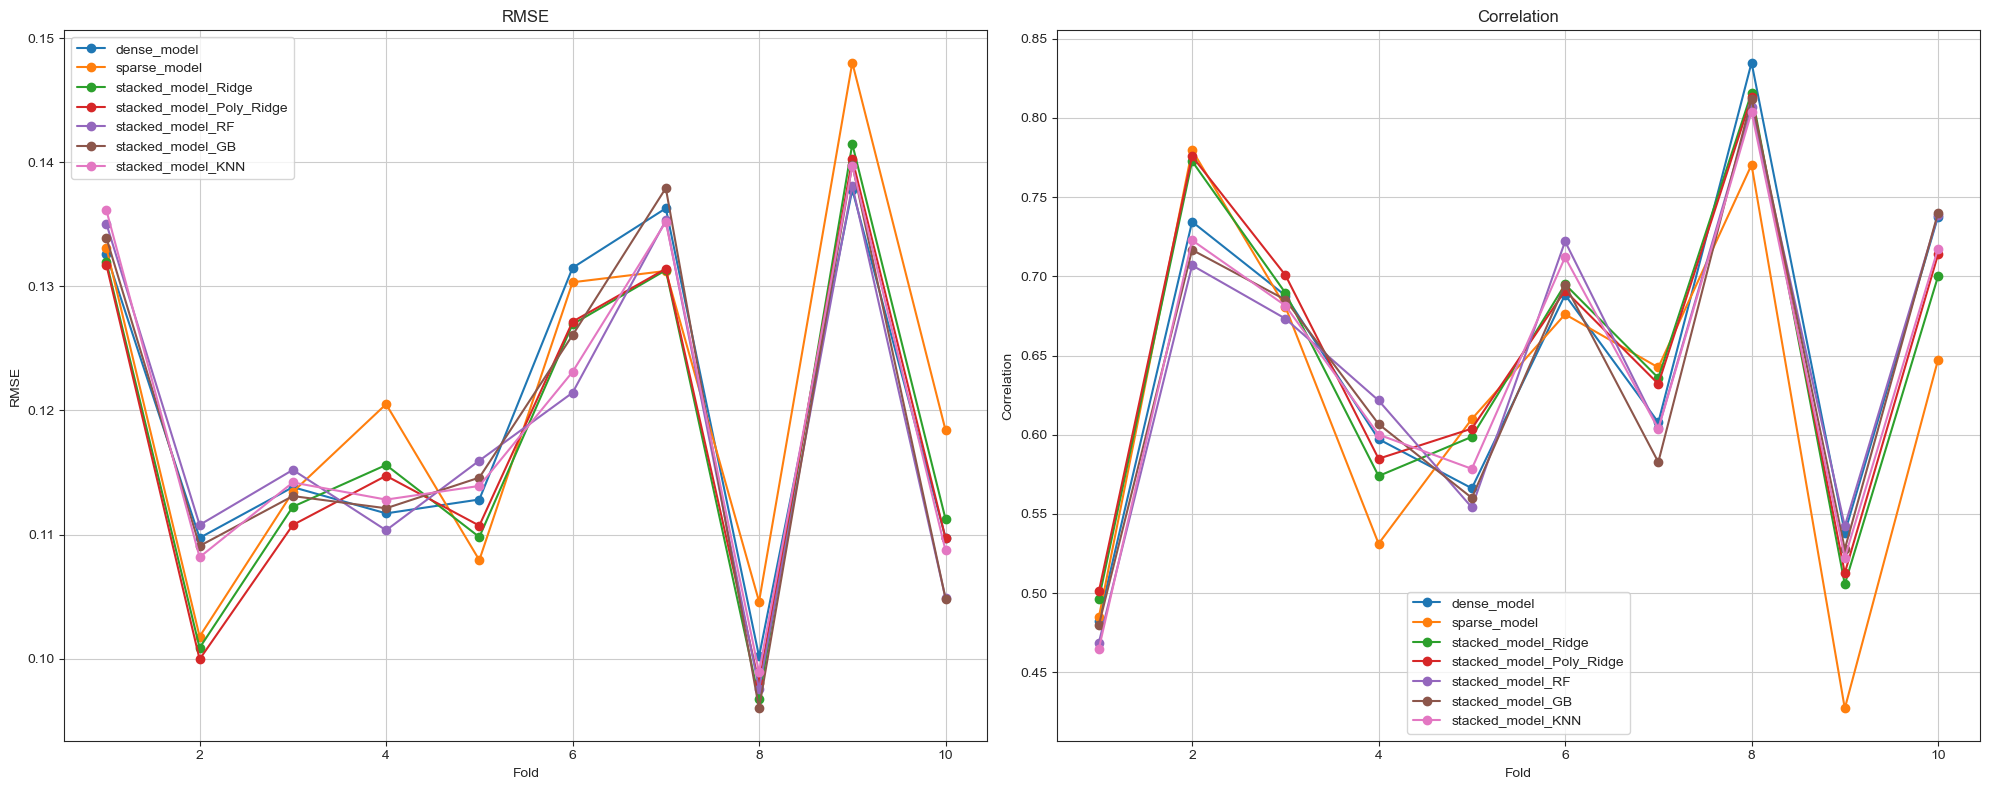

In [16]:
visualize_fold_results_averaged(results['fold_results'])

In [17]:
def print_results(results):
    overall_results = results['performance']
    fold_results = results['fold_results']

    print("Overall Performance:")
    print("=" * 50)
    for model, metrics in overall_results.items():
        print(f"\n{model}:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")

    print("\n\nFold Results Summary:")
    print("=" * 50)
    for model, metrics in fold_results.items():
        print(f"\n{model}:")
        for metric, values in metrics.items():
            mean_value = np.mean(values)
            std_value = np.std(values)
            min_value = np.min(values)
            max_value = np.max(values)
            print(f"  {metric}:")
            print(f"    Mean ± Std: {mean_value:.4f} ± {std_value:.4f}")
            print(f"    Min: {min_value:.4f}")
            print(f"    Max: {max_value:.4f}")

In [18]:
print_results(results)

Overall Performance:

dense_model:
  RMSE: 0.1203
  Correlation: 0.6511

sparse_model:
  RMSE: 0.1217
  Correlation: 0.6286

stacked_model_Ridge:
  RMSE: 0.1186
  Correlation: 0.6525

stacked_model_Poly_Ridge:
  RMSE: 0.1182
  Correlation: 0.6563

stacked_model_RF:
  RMSE: 0.1192
  Correlation: 0.6507

stacked_model_GB:
  RMSE: 0.1196
  Correlation: 0.6470

stacked_model_KNN:
  RMSE: 0.1198
  Correlation: 0.6462


Fold Results Summary:

dense_model:
  RMSE:
    Mean ± Std: 0.1196 ± 0.0128
    Min: 0.1002
    Max: 0.1378
  Correlation:
    Mean ± Std: 0.6476 ± 0.1020
    Min: 0.4826
    Max: 0.8350

sparse_model:
  RMSE:
    Mean ± Std: 0.1209 ± 0.0139
    Min: 0.1018
    Max: 0.1480
  Correlation:
    Mean ± Std: 0.6250 ± 0.1093
    Min: 0.4272
    Max: 0.7798

stacked_model_Ridge:
  RMSE:
    Mean ± Std: 0.1178 ± 0.0138
    Min: 0.0967
    Max: 0.1415
  Correlation:
    Mean ± Std: 0.6484 ± 0.1009
    Min: 0.4963
    Max: 0.8160

stacked_model_Poly_Ridge:
  RMSE:
    Mean ± Std: 0.117

### 3. Train final models

Here we train two final models, without and with leaderboard augmentation.

In [19]:

def predict_base_models(X_dense_new, X_sparse_new, final_models):
    base_predictions = {'dense': [], 'sparse': []}
    
    for _, models in final_models.items():
        for dense_model, sparse_model, _ in models:
            dense_pred = dense_model.predict(X_dense_new)
            sparse_pred = sparse_model.predict(X_sparse_new)
            dense_pred = (dense_pred[0::2] + dense_pred[1::2])/2
            sparse_pred = (sparse_pred[0::2] + sparse_pred[1::2])/2          
            base_predictions['dense'].append(dense_pred)
            base_predictions['sparse'].append(sparse_pred)


    # Calculate mean predictions for base models
    base_predictions_mean = {
        'dense': np.mean(base_predictions['dense'], axis=0),
        'sparse': np.mean(base_predictions['sparse'], axis=0)
    }
    
    return base_predictions, base_predictions_mean

def evaluate_performance(y_true, y_pred):
    y_true = (y_true[0::2] + y_true[1::2])/2
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    corr, _ = pearsonr(y_true, y_pred)
    return rmse, corr



In [20]:
def train_final_models(X_dense, X_sparse, y, base_model_dense_class, base_model_sparse_class, meta_models, n_models=10, seed = 0):
    final_models = {name: [] for name in meta_models.keys()}
    
    for seed in range(seed, n_models+ seed):
        base_model_dense = base_model_dense_class(**best_rf_dense, random_state=seed)
        base_model_sparse = base_model_sparse_class(**best_rf_sparse, random_state=seed)
        
        # Train base models
        final_base_model_dense = base_model_dense.fit(X_dense, y)
        final_base_model_sparse = base_model_sparse.fit(X_sparse, y)
        
        # Generate averaged predictions for meta models
        dense_preds = final_base_model_dense.predict(X_dense)
        sparse_preds = final_base_model_sparse.predict(X_sparse)
        
        dense_preds_avg = (dense_preds[0::2] + dense_preds[1::2]) / 2
        sparse_preds_avg = (sparse_preds[0::2] + sparse_preds[1::2]) / 2
        
        final_meta_features = np.column_stack((dense_preds_avg, sparse_preds_avg))
        y_avg = (y[0::2] + y[1::2]) / 2
        for name, meta_model_class in meta_models.items():
            if name == 'Poly_Ridge':
                meta_model = meta_model_class.fit(final_meta_features, y_avg)
            elif name == 'KNN':
                meta_model = meta_model_class().fit(final_meta_features, y_avg)
            else:
                meta_model = meta_model_class(random_state=seed).fit(final_meta_features, y_avg)
            final_models[name].append((final_base_model_dense, final_base_model_sparse, meta_model))
    return final_models


def predict_stacked_ensemble(X_dense_new, X_sparse_new, final_models):
    predictions = {name: [] for name in final_models.keys()}
    
    for name, models in final_models.items():
        for dense_model, sparse_model, meta_model in models:
            dense_pred = dense_model.predict(X_dense_new)
            sparse_pred = sparse_model.predict(X_sparse_new)
            
            dense_pred_avg = (dense_pred[0::2] + dense_pred[1::2]) / 2
            sparse_pred_avg = (sparse_pred[0::2] + sparse_pred[1::2]) / 2
            
            meta_features = np.column_stack((dense_pred_avg, sparse_pred_avg))
            meta_pred = meta_model.predict(meta_features)
            predictions[name].append(meta_pred)
    
    return {name: np.mean(preds, axis=0) for name, preds in predictions.items()}

In [21]:
# Define meta-models, a bit different from cv, as here random state and other argument are specified within the loop
meta_models = {
    'Ridge': Ridge,
    'Poly_Ridge': make_pipeline(PolynomialFeatures(degree=2), Ridge()),
    'RF': RandomForestRegressor,
    'GB': GradientBoostingRegressor,
    'KNN': KNeighborsRegressor
}

In [ ]:
# Train final models
final_models = train_final_models(X_dense_train, X_sparse_train, y_true_train, RandomForestRegressor, RandomForestRegressor, meta_models)
final_models_aug = train_final_models(X_dense_all, X_sparse_all, y_true_all, RandomForestRegressor, RandomForestRegressor, meta_models)

In [ ]:
final_models_2 = train_final_models(X_dense_train, X_sparse_train, y_true_train, RandomForestRegressor, RandomForestRegressor, meta_models, seed = 10)
final_models_aug_2 = train_final_models(X_dense_all, X_sparse_all, y_true_all, RandomForestRegressor, RandomForestRegressor, meta_models, seed = 10)

In [ ]:
# Evaluate on training data
train_predictions = predict_stacked_ensemble(X_dense_train, X_sparse_train, final_models)
train_predictions_aug =  predict_stacked_ensemble(X_dense_all, X_sparse_all, final_models_aug)

In [ ]:
print("Training on Training Set Performance:")
print()
for name, preds in train_predictions.items():
    rmse, corr = evaluate_performance(y_true_train, preds)
    print(f"{name} - RMSE: {rmse:.4f}, Correlation: {corr:.4f}")
print()

print("Training on Training + Leaderbarod Performance:")
print()
for name, preds in train_predictions_aug.items():
    rmse, corr = evaluate_performance(y_true_all, preds)
    print(f"{name} - RMSE: {rmse:.4f}, Correlation: {corr:.4f}")

### 4. Eval on leaderboard

In [ ]:
print("\nLeaderbaord Performance (base models):")
print()

base_predictions, base_predictions_mean = predict_base_models(X_dense_leaderboard, X_sparse_leaderboard, final_models)

for name, preds in base_predictions_mean.items():
    rmse, corr = evaluate_performance(y_true_leaderboard, preds) 
    print(f"{name} - RMSE: {rmse:.4f}, Correlation: {corr:.4f}")

In [ ]:
print("\nLeaderbaord Performance (meta models):")
print()
# Evaluate on test data
leaderboard_predictions = predict_stacked_ensemble(X_dense_leaderboard, X_sparse_leaderboard, final_models)

for name, preds in leaderboard_predictions.items():
    rmse, corr = evaluate_performance(y_true_leaderboard, preds)
    print(f"{name} - RMSE: {rmse:.4f}, Correlation: {corr:.4f}")

In [ ]:
print("\nLeaderbaord Performance (meta models):")
print()
# Evaluate on test data
leaderboard_predictions_2 = predict_stacked_ensemble(X_dense_leaderboard, X_sparse_leaderboard, final_models_2)

for name, preds in leaderboard_predictions_2.items():
    rmse, corr = evaluate_performance(y_true_leaderboard, preds)
    print(f"{name} - RMSE: {rmse:.4f}, Correlation: {corr:.4f}")

In [ ]:
# Color map for all data points
num_points = len(leaderboard_predictions[list(leaderboard_predictions.keys())[0]])
colors = plt.cm.magma(np.linspace(0, 1, num_points))


plt.figure(figsize=(5, 5))
    
# Use the same color for each point across all plots
for i in range(num_points):
    plt.scatter(leaderboard_predictions_2['RF'][i], 
                leaderboard_predictions['RF'][i], 
                color=colors[i], 
                alpha=0.7)

plt.xlim(.1, .9)
plt.ylim(.1, .9)
plt.xlabel('Model Prediction 2')
plt.ylabel('Model Prediction 1')
plt.title(f'Meta model: RF')

# Add y=x line
plt.plot([.1, .9], [.1, .9], color='grey', linestyle='--')

plt.tight_layout()
plt.show()

#### Visualizing leaderboard:

In [ ]:
# Color map for all data points
num_points = len(base_predictions_mean[list(base_predictions_mean.keys())[0]])
colors = plt.cm.magma(np.linspace(0, 1, num_points))

for base_model in base_predictions_mean.keys():
    plt.figure(figsize=(5, 5))
    
    # Use the same color for each point across all plots
    for i in range(num_points):
        y_true = (y_true_leaderboard[0::2] +  y_true_leaderboard[1::2])/2
        plt.scatter(y_true[i], 
                    base_predictions_mean[base_model][i], 
                    color=colors[i], 
                    alpha=0.7)

    plt.xlim(.1, .9)
    plt.ylim(.1, .9)
    plt.xlabel('True Value')
    plt.ylabel('Model Prediction')
    plt.title(f'Base model: {base_model}')
    
    # Add y=x line
    plt.plot([.1, .9], [.1, .9], color='grey', linestyle='--')

    # Calculate and add correlation
    correlation, _ = stats.pearsonr(y_true, base_predictions_mean[base_model])
    plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

In [ ]:
# Color map for all data points
num_points = len(leaderboard_predictions[list(leaderboard_predictions.keys())[0]])
colors = plt.cm.magma(np.linspace(0, 1, num_points))

for meta_model in leaderboard_predictions.keys():
    plt.figure(figsize=(5, 5))
    
    # Use the same color for each point across all plots
    for i in range(num_points):
        y_true = (y_true_leaderboard[0::2] +  y_true_leaderboard[1::2])/2
        plt.scatter(y_true[i], 
                    leaderboard_predictions[meta_model][i], 
                    color=colors[i], 
                    alpha=0.7)

    plt.xlim(.1, .9)
    plt.ylim(.1, .9)
    plt.xlabel('True Value')
    plt.ylabel('Model Prediction')
    plt.title(f'Meta model: {meta_model}')
    
    # Add y=x line
    plt.plot([.1, .9], [.1, .9], color='grey', linestyle='--')

    # Calculate and add correlation
    correlation, _ = stats.pearsonr(y_true, leaderboard_predictions[meta_model])
    plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()

### 5. Compare correaltion of final models trained with and without leaderboard data

In [ ]:
test_predictions = predict_stacked_ensemble(X_dense_test, X_sparse_test, final_models)
test_predictions_aug = predict_stacked_ensemble(X_dense_test, X_sparse_test, final_models_aug)

In [ ]:
test_predictions_aug_2 = predict_stacked_ensemble(X_dense_test, X_sparse_test, final_models_aug_2)

#### Visualizing Test:

In [ ]:
# Color map for all data points
num_points = len(test_predictions[list(test_predictions.keys())[0]])
colors = plt.cm.viridis(np.linspace(0, 1, num_points))

plt.figure(figsize=(5, 5))

# Use the same color for each point across all plots
for i in range(num_points):
    plt.scatter(test_predictions_aug['RF'][i], 
                test_predictions_aug_2['RF'][i], 
                color=colors[i], 
                alpha=0.7)

plt.xlim(.4, .8)
plt.ylim(.4, .8)
plt.xlabel('Model Prediction 1')
plt.ylabel('Model Prediction 2')
plt.title(f'Meta model: RF')

# Add y=x line
plt.plot([.4, .8], [.4, .8], color='grey', linestyle='--')

plt.tight_layout()
plt.show()

In [ ]:
def create_submission_files(meta_model, out_folder):
    # Read to be filled out form
    leaderboards_submission_form = pd.read_csv('./Test/Submission/Leaderboard_set_Submission_form.csv', index_col = 0)
    test_submission_form = pd.read_csv('./Test/Submission/Test_set_Submission_form.csv', index_col = 0)
    print(f'Test_submission_form created for {meta_model}')
    
    # Write prediction column
    # Use model trained on training
    leaderboards_submission_form['Predicted_Experimental_Values'] = leaderboard_predictions[meta_model] 
    # Use model trained on training + Leaderboard
    test_submission_form['Predicted_Experimental_Values'] = test_predictions_aug[meta_model] 
    print(f'Leaderboard_submission_form created for {meta_model}')

    leaderboards_submission_form.to_csv(f'./Test/Submission/{out_folder}/Leaderboard_set_Submission_form_{meta_model}.csv')
    test_submission_form.to_csv(f'./Test/Submission/{out_folder}/Test_set_Submission_form_{meta_model}.csv')

In [ ]:
meta_model = 'RF'
out_folder = 'Meta_symmetric_final'

In [ ]:
create_submission_files(meta_model, out_folder)